In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# Load your data into a DataFrame (adjust the path accordingly)
data = pd.read_csv(r"C:\Users\thepr\Documents\Clone_Desktop\cotton.csv")

In [3]:
cotton_raj = data[['date','rj_price']]

In [4]:
cotton_raj

,date,rj_price
0,2010-01-01,3375.0
1,2010-01-02,3375.0
2,2010-01-03,3375.0
3,2010-01-04,3375.0
4,2010-01-05,3375.0
...,...,...
5028,2023-10-08,7230.0
5029,2023-10-09,7100.0
5030,2023-10-10,7200.0
5031,2023-10-11,7125.0


In [5]:
cotton_raj
cotton_raj.set_index('date',inplace=True)

In [6]:
cotton_raj

,rj_price
date,
2010-01-01,3375.0
2010-01-02,3375.0
2010-01-03,3375.0
2010-01-04,3375.0
2010-01-05,3375.0
...,...
2023-10-08,7230.0
2023-10-09,7100.0
2023-10-10,7200.0


In [7]:
# Normalize the data
scaler = MinMaxScaler()
scaled_cotton_raj = scaler.fit_transform(cotton_raj)

In [8]:
# Create sequences of data
sequence_length = 30 # Adjust as needed
X, y = [], []
for i in range(len(cotton_raj) - sequence_length - 1):
    X.append(scaled_cotton_raj[i:i+sequence_length])
    y.append(scaled_cotton_raj[i+sequence_length+1])

In [9]:
X, y = np.array(X, dtype=np.float32), np.array(y,dtype=np.float32)

In [10]:
print(X.shape, y.shape)

(5002, 30, 1) (5002, 1)


In [11]:
# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4001, 30, 1) (1001, 30, 1) (4001, 1) (1001, 1)


In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(30, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [14]:
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
63/63 [==============================] - 3s 16ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 2/50
63/63 [==============================] - 1s 10ms/step - loss: 4.2002e-04 - val_loss: 0.0016
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 3.9296e-04 - val_loss: 0.0014
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 3.6658e-04 - val_loss: 0.0014
Epoch 5/50
63/63 [==============================] - 1s 10ms/step - loss: 3.4642e-04 - val_loss: 0.0014
Epoch 6/50
63/63 [==============================] - 1s 10ms/step - loss: 3.3903e-04 - val_loss: 0.0012
Epoch 7/50
63/63 [==============================] - 1s 10ms/step - loss: 3.2274e-04 - val_loss: 0.0013
Epoch 8/50
63/63 [==============================] - 1s 10ms/step - loss: 3.1211e-04 - val_loss: 0.0019
Epoch 9/50
63/63 [==============================] - 1s 10ms/step - loss: 3.2240e-04 - val_loss: 0.0016
Epoch 10/50
63/63 [==============================] - 1s 10ms/step - loss: 2.9

In [15]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [16]:
y_train_act = cotton_raj.values[:len(X_train)].reshape(4001,)
y_test_act = cotton_raj.values[len(X_train):5002].reshape(1001,)
y_train_pred = scaler.inverse_transform(y_train_pred).reshape(4001,)
y_test_pred = scaler.inverse_transform(y_test_pred).reshape(1001,)

# `Forecasting for Next 30 days` 

In [17]:
X = np.array(X_test[-1])

In [18]:
def pred_n_days(model, data, days):
    
    predictions = []
    
    for i in range(days):
        
        data = data.reshape(30,1)
        data = np.expand_dims(data,axis=0)
    
        curr_pred = model.predict(data)
        curr_pred = curr_pred.reshape(1,1)
        predictions.append(curr_pred[0])
        
        curr_pred = np.expand_dims(curr_pred,axis=0)
        data= data[0][1:].reshape((1, 29, 1))
        data = np.concatenate((data,curr_pred),axis=1)
        
    return np.array(predictions)

In [19]:
forecast = pred_n_days(model,X,365)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


In [20]:
forecast = scaler.inverse_transform(forecast).reshape(365,)

In [21]:
train_ind = np.array(cotton_raj.index)[:len(X_train)]
test_ind = np.array(cotton_raj.index)[len(X_train):5002] 

In [22]:
from datetime import datetime, timedelta

# Input date in YYYY-MM-DD format
input_date = test_ind[-1]

# Convert the input date to a datetime object
start_date = datetime.strptime(input_date, "%Y-%m-%d")

# Calculate the next 365 days
next_365_days = [start_date + timedelta(days=i) for i in range(365)]

# Convert the datetime objects back to date strings
next_365_days_str = [date.strftime("%Y-%m-%d") for date in next_365_days]

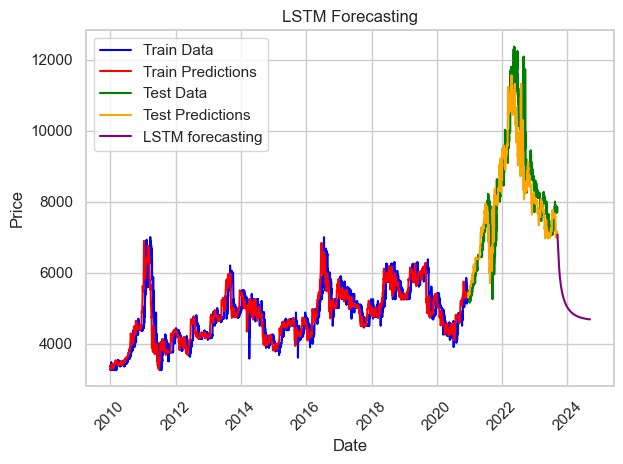

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime

# Set the Seaborn style
sns.set(style="whitegrid")

# Create a figure and axis
# plt.figure(figsize=(10, 7))

# Convert your date strings to datetime objects
train_dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in train_ind]
test_dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in test_ind]
forecast_dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in next_365_days_str]

# Plot actual vs. predicted values using Seaborn
sns.lineplot(x=train_dates, y=y_train_act, label='Train Data', color='blue')
sns.lineplot(x=train_dates, y=y_train_pred, label='Train Predictions', color='red')
sns.lineplot(x=test_dates, y=y_test_act, label='Test Data', color='green')
sns.lineplot(x=test_dates, y=y_test_pred, label='Test Predictions', color='orange')
sns.lineplot(x=forecast_dates, y=forecast, label='LSTM forecasting', color='purple')

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM Forecasting')

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add grid lines
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend and show the plot
plt.legend()
plt.tight_layout()

plt.savefig(r"C:\Users\thepr\Desktop\LSTM1.png",dpi=300)
plt.show()



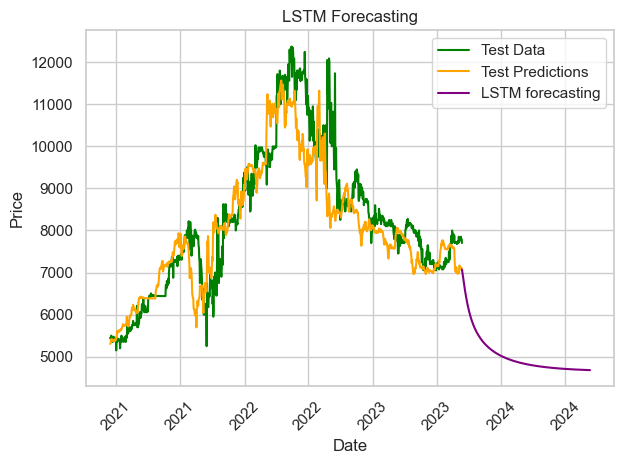

In [24]:
#sns.set(style="darkgrid")

sns.lineplot(x=test_dates, y=y_test_act, label='Test Data', color='green')
sns.lineplot(x=test_dates, y=y_test_pred, label='Test Predictions', color='orange')
sns.lineplot(x=forecast_dates, y=forecast, label='LSTM forecasting', color='purple')

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM Forecasting')

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add grid lines
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend and show the plot
plt.legend()
plt.tight_layout()

plt.savefig(r"C:\Users\thepr\Desktop\LSTM2.png",dpi=300)
plt.show()



In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_act, y_test_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 599180.2109605024
Root Mean Squared Error (RMSE): 774.0673168145664
